## Clear In-Memory IPython Variables

In [ ]:
from IPython import get_ipython

In [ ]:
get_ipython().run_line_magic('reset','-sf')

# Statistical/Hypothetical Question
Question: "How do market dynamics such as pending sales, inventory levels, months of supply, and median days on market influence the median sale price of homes in Nebraska?"

This question aims to explore the relationships between key housing market variables and the median sale price. The hypothesis is that these variables have significant effects on the median sale price, with different factors either driving up or pushing down prices depending on market conditions.

# Main Script

## Import Necessary Libraries

In [1]:
# Import essential libraries for data manipulation, visualization, and statistical analysis.
import pandas as pd
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from IPython.display import display, HTML
import io
from sklearn.linear_model import LinearRegression
import numpy as np
import polars as pl
import gc
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import basename, exists
from urllib.request import urlretrieve
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind


# Define function to download necessary files if they don't exist locally.
def download(url):
    filename = basename(url)
    if not exists(filename):
        local, _ = urlretrieve(url, filename)
        print(f"Downloaded {local}")

# Download required scripts for additional statistical functions and plotting
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
import thinkstats2
import thinkplot

## Read Necessary File(s)

In [2]:
# Define the file path for the dataset dynamically
file_path = Path(r'C:\Users\jacob\DSC530 - Data Exploration and Analysis\Final Project\city_market_tracker.tsv000')
resolved_path = file_path.resolve()

# Load the dataset into a pandas DataFrame, using tab as the delimiter
df = pd.read_csv(resolved_path, delimiter='\t')

## Read Dataset Structure and Basic Summary Statistics

In [3]:
# Class to display DataFrame with scrollable output
class ScrollableDataFrameDisplay:
    def __init__(self, df):
        self.df = df

    # Method to display various DataFrame information in a scrollable format
    def display_function(self, func):
        if func.__name__ == 'info':
            buffer = io.StringIO()
            func(buf=buffer)
            output_html = buffer.getvalue()
            display(HTML('<pre style="overflow-x: auto;">{}</pre>'.format(output_html)))
        elif func.__name__ == 'describe':
            output_html = func().to_html()
            display(HTML('<div style="overflow-x: auto;">{}</div>'.format(output_html)))
        else:
            output_html = func().to_html()
            display(HTML('<div style="overflow-x: auto;">{}</div>'.format(output_html)))

# Class to handle interpolation of missing values using the Polars DataFrame
class PolarsDataFrameInterpolator:
    def __init__(self, df):
        # Convert the Pandas DataFrame to Polars DataFrame for efficient computation
        self.df = pl.DataFrame(df)

    # Method to interpolate missing values in a specific column
    def interpolate_column(self, column):
        data = self.df[column].to_numpy()

        for i in range(len(data)):
            if np.isnan(data[i]):
                # Find available lag values within the last 6 records
                lags = data[max(0, i-6):i][~np.isnan(data[max(0, i-6):i])]

                if len(lags) > 0:
                    # Use a linear regression approach to estimate missing values using the last 6 non-missing values
                    X_lag = np.array(range(1, len(lags) + 1)).reshape(-1, 1)
                    y_lag = lags
                    model = LinearRegression().fit(X_lag, y_lag)
                    data[i] = model.predict(np.array([[len(lags) + 1]]))[0]

                else:
                    # If no lag values are available, use the average of the next two non-missing lead values
                    leads = data[i+1:i+3][~np.isnan(data[i+1:i+3])]
                    if len(leads) > 0:
                        data[i] = leads.mean()

        # Update the Polars DataFrame with the interpolated column
        self.df = self.df.with_column(pl.Series(column, data))

    # Method to interpolate all columns of a specific data type (e.g., float)    
    def interpolate_by_dtype(self, dtype):
        # Get columns that match the specified data type
        matching_columns = [col for col, col_dtype in self.df.schema.items() if col_dtype == dtype]
        
        for column in matching_columns:
            self.interpolate_column(column)

        # Convert back to Pandas DataFrame for compatibility with other Python libraries
        return self.df.to_pandas()

# Function to print memory usage of all variables, useful for optimizing resource usage
def memory_usage():
    # Create a list of dictionaries containing variable names and their memory usage
    memory_data = [{'Variable': name, 'Storage (bytes)': sys.getsizeof(value)} 
                   for name, value in globals().items() if not name.startswith("__")]

    # Create a DataFrame from the list
    mem_df = pd.DataFrame(memory_data)
    print(mem_df.sort_values(by='Storage (bytes)',ascending=False))


# Display the shape of the dataset to understand its dimensions
print(df.shape, '\n')

# Instantiate the interpolator and perform interpolation
interpolator = PolarsDataFrameInterpolator(df)
del df # Free up memory
gc.collect() # Force garbage collection to free memory
df_interpolated = interpolator.interpolate_by_dtype(float)

# Display basic info and statistics of the interpolated DataFrame
df_display_interp = ScrollableDataFrameDisplay(df_interpolated)
df_display_interp.display_function(df_interpolated.info)
df_display_interp.display_function(df_interpolated.describe)

# Display memory usage to assess the efficiency of data handling
memory_usage()

(5484743, 58) 



,period_duration,region_type_id,table_id,property_type_id,median_sale_price,median_sale_price_mom,median_sale_price_yoy,median_list_price,median_list_price_mom,median_list_price_yoy,median_ppsf,median_ppsf_mom,median_ppsf_yoy,median_list_ppsf,median_list_ppsf_mom,median_list_ppsf_yoy,homes_sold,homes_sold_mom,homes_sold_yoy,pending_sales,pending_sales_mom,pending_sales_yoy,new_listings,new_listings_mom,new_listings_yoy,inventory,inventory_mom,inventory_yoy,months_of_supply,months_of_supply_mom,months_of_supply_yoy,median_dom,median_dom_mom,median_dom_yoy,avg_sale_to_list,avg_sale_to_list_mom,avg_sale_to_list_yoy,sold_above_list,sold_above_list_mom,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region_metro_code
count,5484743.0,5484743.0,5.484743e+06,5.484743e+06,5.478607e+06,4.456420e+06,4.354425e+06,4.587693e+06,3.858733e+06,3.753857e+06,5.413124e+06,4.400987e+06,4.298636e+06,4.567932e+06,3.839651e+06,3.734372e+06,5.479033e+06,4.456803e+06,4.354844e+06,4.288128e+06,3.471278e+06,3.351882e+06,4.567323e+06,3.840582e+06,3.731766e+06,5.044731e+06,4.242408e+06,4.102142e+06,5.123641e+06,4.307811e+06,4.176481e+06,5.411637e+06,4.392197e+06,4.285978e+06,5.290483e+06,4.310137e+06,4.214759e+06,5.447566e+06,4.431709e+06,4.329359e+06,2.875354e+06,2.379077e+06,2.165139e+06,4.393972e+06,3.558938e+06,3.433459e+06,5.484743e+06
mean,30.0,6.0,1.809156e+04,3.455593e+00,3.098479e+05,7.390623e-01,1.297157e+00,3.467580e+05,8.190394e-02,1.524037e-01,1.905536e+02,7.800567e-01,1.346074e+00,2.149822e+02,3.291880e-01,1.784807e-01,1.463481e+01,2.245361e-01,2.656555e-01,1.468957e+01,2.266902e-01,3.155520e-01,2.029793e+01,2.272005e-01,2.348518e-01,4.833222e+01,2.624295e-02,9.676251e-02,4.251446e+00,-9.514888e-02,-5.033331e-01,9.992478e+01,-8.757961e-01,-8.929787e+00,9.736957e-01,2.776673e-04,3.815224e-03,2.322039e-01,1.412393e-03,1.753751e-02,2.738950e-01,4.366410e-03,8.021343e-03,2.827142e-01,-7.562213e-04,1.810564e-02,3.050342e+04
std,0.0,0.0,1.051731e+04,4.182493e+00,4.178763e+05,2.493500e+02,4.119516e+02,1.407245e+06,2.444108e+00,2.806859e+00,5.967643e+03,2.838274e+02,4.271093e+02,3.333936e+04,3.191435e+02,1.787144e+01,5.623580e+01,9.758783e-01,1.686969e+00,5.476752e+01,9.550112e-01,1.364179e+00,7.624012e+01,9.917150e-01,1.076078e+00,2.060376e+02,3.808192e-01,9.766119e-01,5.058385e+00,4.921306e+00,5.934189e+00,2.192579e+02,2.328979e+02,2.384484e+02,6.081007e-02,6.234084e-02,6.419754e-02,2.940894e-01,3.106071e-01,3.217211e-01,1.879024e-01,1.612046e-01,1.755620e-01,3.115689e-01,3.094562e-01,3.226855e-01,1.153031e+04
min,30.0,6.0,3.000000e+00,-1.000000e+00,1.000000e+00,-9.999950e-01,-9.999951e-01,2.900000e+02,-9.994370e-01,-9.999550e-01,2.500000e-04,-9.999965e-01,-9.999970e-01,3.992174e-03,-9.999431e-01,-9.998754e-01,1.000000e+00,-9.914530e-01,-9.914530e-01,1.000000e+00,-9.864865e-01,-9.864865e-01,1.000000e+00,-9.923077e-01,-9.830508e-01,1.000000e+00,-9.677419e-01,-9.878049e-01,0.000000e+00,-1.026300e+03,-1.157000e+03,1.000000e+00,-4.124200e+04,-4.130500e+04,5.000000e-01,-1.310783e+00,-1.270707e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,1.090869e-04,-9.729730e-01,-9.736842e-01,0.000000e+00,-2.000000e+00,-2.000000e+00,1.010000e+04
25%,30.0,6.0,9.311000e+03,-1.000000e+00,1.339500e+05,-1.369606e-01,-8.695652e-02,1.562500e+05,-1.067527e-01,-5.846154e-02,8.573257e+01,-1.007589e-01,-5.212283e-02,9.698661e+01,-7.146856e-02,-2.560649e-02,1.000000e+00,-3.000000e-01,-3.000000e-01,2.000000e+00,-3.076923e-01,-2.857143e-01,2.000000e+00,-3.076923e-01,-2.916667e-01,5.000000e+00,-1.347150e-01,-3.125000e-01,1.600000e+00,-1.200000e+00,-1.900000e+00,2.900000e+01,-2.400000e+01,-3.400000e+01,9.541002e-01,-1.958242e-02,-1.874097e-02,0.000000e+00,-9.202899e-02,-8.333333e-02,1.500000e-01,-7.142857e-02,-7.777778e-02,0.000000e+00,-1.111111e-01,-1.000000e-01,1.946000e+04
50%,30.0,6.0,1.792600e+04,4.000000e+00,2.194500e+05,6.036217e-03,7.742685e-02,2.499000e+05,3.064921e-03

                       Variable  Storage (bytes)
46              df_interpolated       6105478505
41                          _i3             3968
16            ColumnTransformer             1688
19                         HTML             1688
43  PolarsDataFrameInterpolator             1688
42   ScrollableDataFrameDisplay             1688
17         make_column_selector             1688
21             LinearRegression             1688
11                          _ii             1220
13                          _i1             1220
15                         Path              920
10                           _i              371
38                          _i2              371
34                    ttest_ind              152
28                     basename              152
18                      display              152
35                     download              152
29                       exists              152
30                  urlretrieve              152
8                   

In [4]:
# Retain Local Pricing
df_interpolated = df_interpolated[df_interpolated['state']=='Nebraska']

## Description of Selected Variables

The following five variables have been selected for analysis:

1. Median Sale Price (median_sale_price)
Description: This variable represents the median sale price of homes within the dataset. It is a key indicator of the central tendency of home prices, providing insight into the overall market conditions.
Relevance to Hypothesis: Median sale price is crucial for understanding market trends and the effects of supply and demand on housing prices. It directly influences buyer and seller behavior, making it a central focus for any analysis related to real estate economics.
2. Pending Sales (pending_sales)
Description: This variable captures the number of homes currently under contract or pending sale. It reflects active market demand and can be used as a leading indicator of future sales trends.
Relevance to Hypothesis: Pending sales provide insight into the current demand within the housing market. Analyzing this variable alongside others like median sale price and inventory can help predict future price movements and market saturation.
3. Inventory (inventory)
Description: Inventory represents the total number of homes available for sale at any given time. It is a measure of supply within the market.
Relevance to Hypothesis: Inventory levels are directly related to market conditions such as buyer competition and price trends. Low inventory often leads to higher prices due to increased competition, whereas high inventory can result in lower prices.
4. Months of Supply (months_of_supply)
Description: Months of supply is a measure that indicates how long it would take to sell the current inventory of homes at the current sales pace. It is calculated as the ratio of inventory to pending sales.
Relevance to Hypothesis: This variable helps assess market balance. A lower months of supply indicates a seller's market with high demand and rising prices, while a higher months of supply suggests a buyer's market with more available homes than buyers.
5. Median Days on Market (median_dom)
Description: This variable measures the median number of days that homes stay on the market before being sold. It provides insight into the speed at which homes are selling.
Relevance to Hypothesis: Median days on market is an important indicator of market liquidity. A shorter duration indicates a hot market where homes sell quickly, while a longer duration may suggest a slowdown in buyer interest or overpricing.

Each of these variables is chosen based on its potential impact on the statistical question being investigated.

## Data Type Conversion for Date Columns

In [5]:
# Function to convert specified columns to datetime format, crucial for time series analysis
def convert_columns_to_datetime(df, columns):
    for column in columns:
        if column in df.columns:
            df[column] = pd.to_datetime(df[column], errors='coerce')  # Convert to datetime, handling errors
    return df


# Identify date columns and numeric columns for further processing
date_cols = [
    'period_begin', 
    'period_end', 
    'last_updated']
numeric_columns = [
    'median_sale_price',
    'inventory',
    'months_of_supply',
    'pending_sales',
    'median_dom'
]

# Store all columns except datetime columns
remaining_columns = [col for col in df_interpolated.columns if col not in date_cols]

# Display the first few entries of the date columns to verify their content
for i in date_cols:
    print(df_interpolated[i][:3])

# Convert the date columns to datetime
convert_columns_to_datetime(df_interpolated, date_cols)

# Verify the conversion by checking the data types of the date columns
df_interpolated[date_cols].dtypes
type(df_interpolated)

264    2021-11-01
642    2020-03-01
896    2022-08-01
Name: period_begin, dtype: object
264    2021-11-30
642    2020-03-31
896    2022-08-31
Name: period_end, dtype: object
264    2024-07-15 17:39:34
642    2024-07-15 17:39:34
896    2024-07-15 17:39:34
Name: last_updated, dtype: object


C:\Users\jacob\AppData\Local\Temp\ipykernel_13608\3271030357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], errors='coerce')  # Convert to datetime, handling errors
C:\Users\jacob\AppData\Local\Temp\ipykernel_13608\3271030357.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_datetime(df[column], errors='coerce')  # Convert to datetime, handling errors
C:\Users\jacob\AppData\Local\Temp\ipykernel_13608\3271030357.py:5: SettingWithCopyWarning: 


pandas.core.frame.DataFrame

In [6]:
# ColumnTransformer is used to drop datetime columns since they are not required for the immediate analysis.
ct = ColumnTransformer(
    remainder='passthrough',
    transformers=[
        ('drop_datetime', 'drop', make_column_selector(dtype_include=['datetime']))  # Drop date/time columns
    ]
)

# Transform the DataFrame to exclude the date/time columns
interpolated_ct = ct.fit_transform(df_interpolated)

# Convert to more efficient data types to optimize memory usage
df_interpolated_ct = pd.DataFrame(interpolated_ct, columns=remaining_columns)

In [7]:
# Update working dataframe to only include numeric columns
df_interpolated_ct = df_interpolated_ct.drop(columns=[col for col in df_interpolated_ct.columns if col not in numeric_columns])

# Allow python to automatically update the datatypes for each column - anecdotally memory efficient whilst retaining all information
df_interpolated_ct = df_interpolated_ct.convert_dtypes()

In [8]:
# Verify dataframes' datatypes have been converted and makes sense
df_interpolated_ct.dtypes

median_sale_price    Float64
pending_sales          Int64
inventory              Int64
months_of_supply     Float64
median_dom             Int64
dtype: object

In [9]:
# Function to handle outliers by winsorizing (limiting extreme values)
def handle_outliers(df, column, lower_quantile=0.01, upper_quantile=0.99):
    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)
    
    # Fill NaN with a value that won't affect winsorization (e.g., the median)
    df[column] = df[column].fillna(df[column].median())
    
    # Cap values below the lower quantile and above the upper quantile
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    
    return df

# Apply outlier handling to each numeric column
for var in numeric_columns:
    df_interpolated_ct = handle_outliers(df_interpolated_ct, var, lower_quantile=0.01, upper_quantile=0.99)

In [10]:
# Display the correlation matrix to explore relationships between variables
df_interpolated_ct.corr(numeric_only=True)

,median_sale_price,pending_sales,inventory,months_of_supply,median_dom
median_sale_price,1.000000,0.057724,0.011704,-0.119480,-0.169286
pending_sales,0.057724,1.000000,0.896111,-0.077539,-0.126802
inventory,0.011704,0.896111,1.000000,0.037466,-0.100698
months_of_supply,-0.119480,-0.077539,0.037466,1.000000,0.158791
median_dom,-0.169286,-0.126802,-0.100698,0.158791,1.000000


## Histograms and Outlier Identification

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


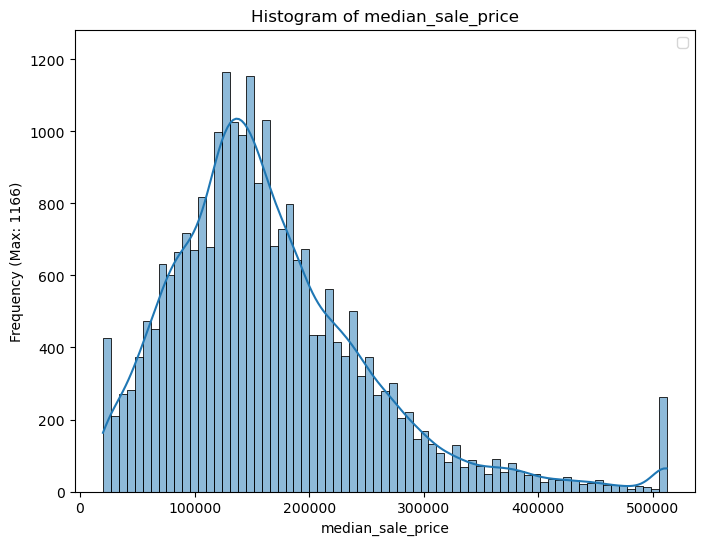

Outliers for median_sale_price:


,median_sale_price
12,511925.0
51,485500.0
85,391500.0
105,435000.0
114,511925.0
...,...
24595,511925.0
24648,432500.0
24664,421000.0
24692,363000.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


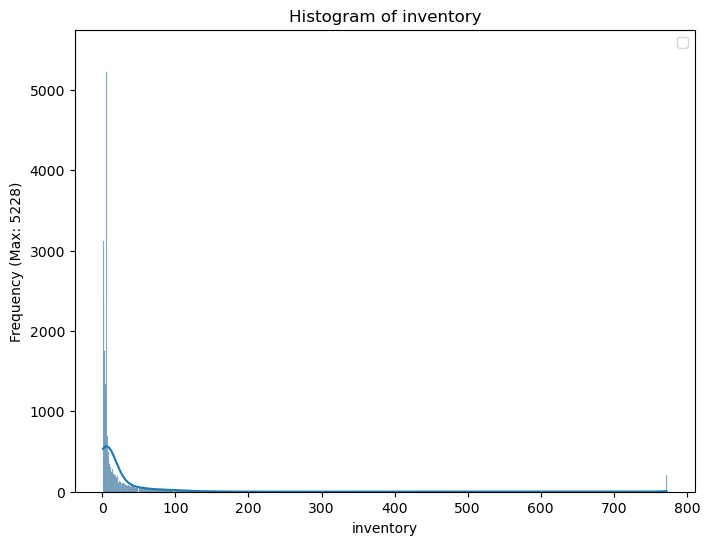

Outliers for inventory:


,inventory
11,87.0
25,56.0
29,45.0
30,40.0
32,128.0
...,...
24683,52.0
24690,51.0
24712,68.0
24716,65.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


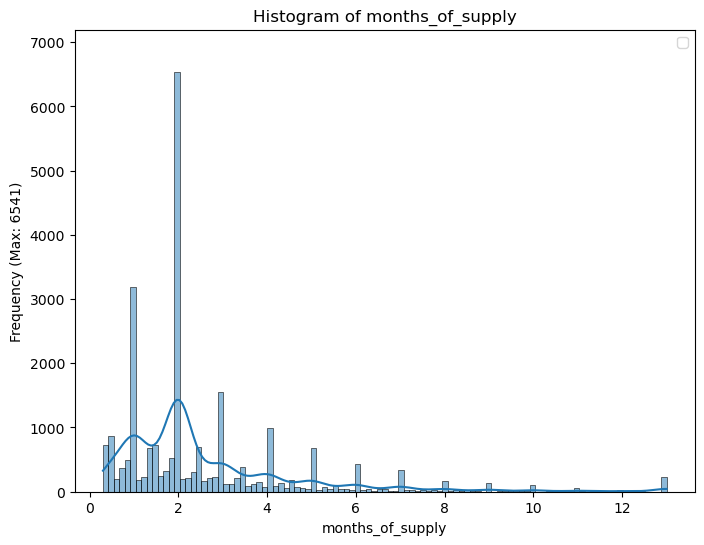

Outliers for months_of_supply:


,months_of_supply
25,7.0
47,13.0
48,13.0
55,6.0
69,13.0
...,...
24663,6.0
24664,8.0
24667,6.0
24673,7.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


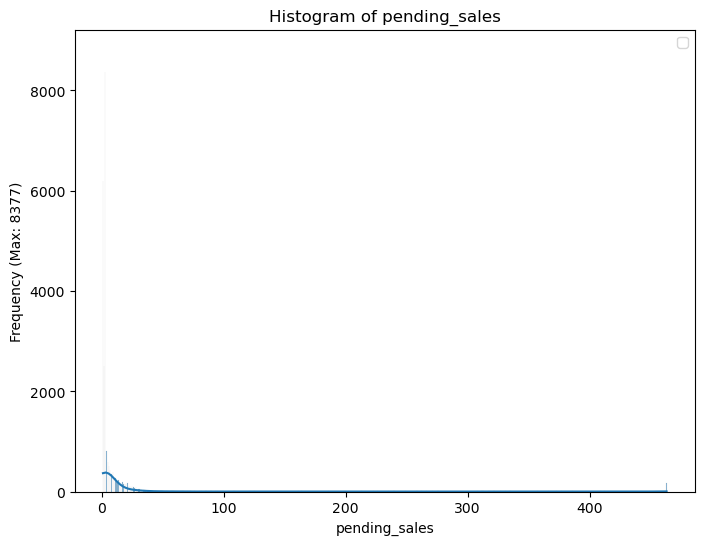

Outliers for pending_sales:


,pending_sales
6,16
11,38
30,20
31,23
32,15
...,...
24683,23
24687,28
24712,16
24716,35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


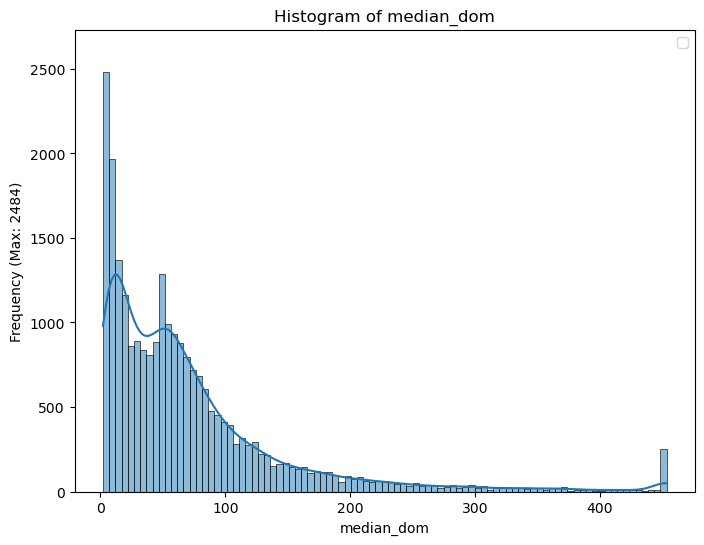

Outliers for median_dom:


,median_dom
1,295.00
4,213.00
23,222.00
27,386.00
35,215.00
...,...
24648,453.65
24664,282.00
24676,453.65
24678,208.00


In [11]:
# Create histograms for each numeric variable to visualize distributions with capped outliers
for var in numeric_columns:
    plt.figure(figsize=(8, 6))
    
    # Plot histogram with a Kernel Density Estimate (KDE) overlay
    hist = sns.histplot(df_interpolated_ct[var], kde=True)
    
    # Dynamically adjust y-axis based on the maximum frequency
    max_freq = hist.patches[0].get_height()
    
    # Set visual limits dynamically
    for patch in hist.patches:
        if patch.get_height() > max_freq:
            max_freq = patch.get_height()
    
    # Set plot titles and labels
    plt.title(f'Histogram of {var}')
    plt.xlabel(var)
    plt.ylabel(f'Frequency (Max: {int(max_freq)})')
    
    # Set the y-limit dynamically
    plt.ylim(0, max_freq + max_freq * 0.1)  # Slight buffer above the max frequency
    plt.legend()
    plt.savefig(f'Histogram - {var}.png')
    plt.show()

    # Use Interquartile Range (IQR) method to identify outliers
    Q1 = df_interpolated_ct[var].quantile(0.25)
    Q3 = df_interpolated_ct[var].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df_interpolated_ct[(df_interpolated_ct[var] < (Q1 - 1.5 * IQR)) | (df_interpolated_ct[var] > (Q3 + 1.5 * IQR))]
    print(f"Outliers for {var}:")
    display(outliers[[var]])

## Descriptive Statistics

In [12]:
# Calculate and display key descriptive statistics (mean, mode, spread, tails) for each variable
for var in numeric_columns:
    print(f"Descriptive statistics for {var}:")
    print(f"Mean: {df_interpolated_ct[var].mean():_.2f}")
    print(f"Mode: {df_interpolated_ct[var].mode()[0]:_.2f}")
    print(f"Spread (Standard Deviation): {df_interpolated_ct[var].std():_.2f}")
    print(f"Tails (Min, Max): {df_interpolated_ct[var].min():_.2f}, {df_interpolated_ct[var].max():_.2f}")
    print("\n")

Descriptive statistics for median_sale_price:
Mean: 165_850.79
Mode: 160_000.00
Spread (Standard Deviation): 89_124.61
Tails (Min, Max): 20_000.00, 511_925.00


Descriptive statistics for inventory:
Mean: 29.92
Mode: 6.00
Spread (Standard Deviation): 95.61
Tails (Min, Max): 1.00, 772.09


Descriptive statistics for months_of_supply:
Mean: 2.61
Mode: 2.00
Spread (Standard Deviation): 2.13
Tails (Min, Max): 0.30, 13.00


Descriptive statistics for pending_sales:
Mean: 14.44
Mode: 3.00
Spread (Standard Deviation): 55.46
Tails (Min, Max): 1.00, 463.00


Descriptive statistics for median_dom:
Mean: 71.80
Mode: 4.00
Spread (Standard Deviation): 79.18
Tails (Min, Max): 2.00, 453.65




## PMF, CDF, and Analytical Distribution

Writing PMF - median_sale_price.pdf
Writing PMF - median_sale_price.png


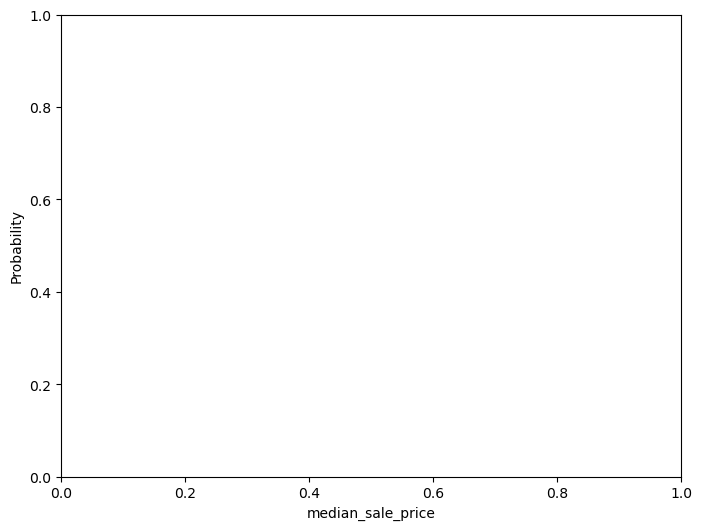

Writing CDF - median_sale_price.pdf
Writing CDF - median_sale_price.png


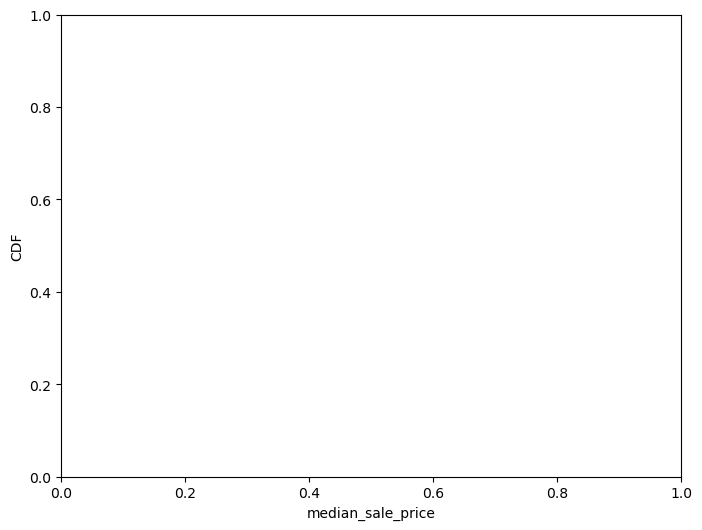

<Figure size 800x600 with 0 Axes>

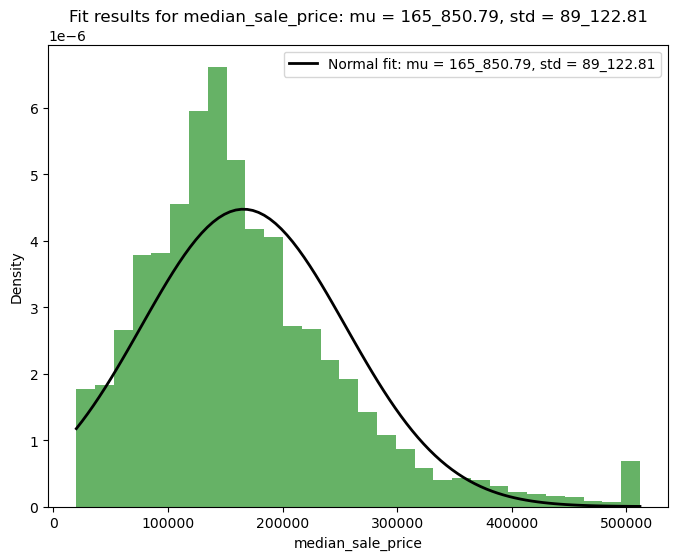

Writing PMF - pending_sales.pdf
Writing PMF - pending_sales.png


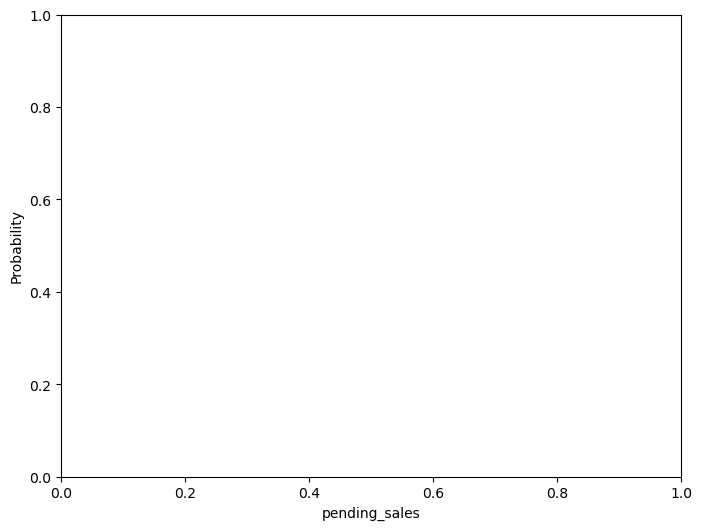

Writing CDF - pending_sales.pdf
Writing CDF - pending_sales.png


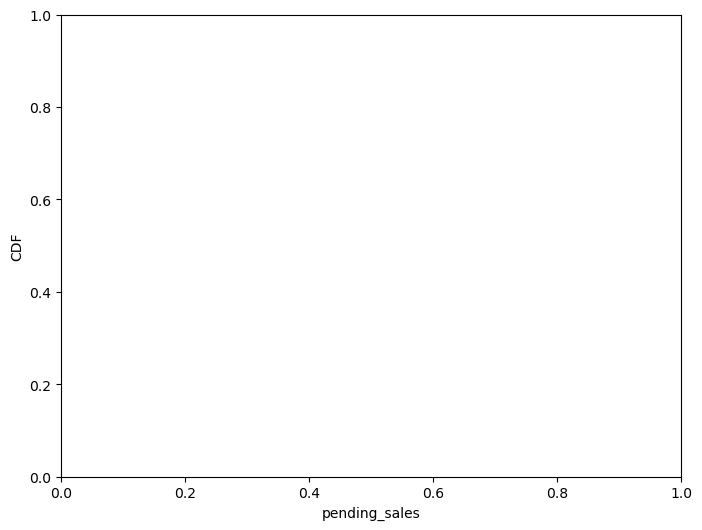

<Figure size 800x600 with 0 Axes>

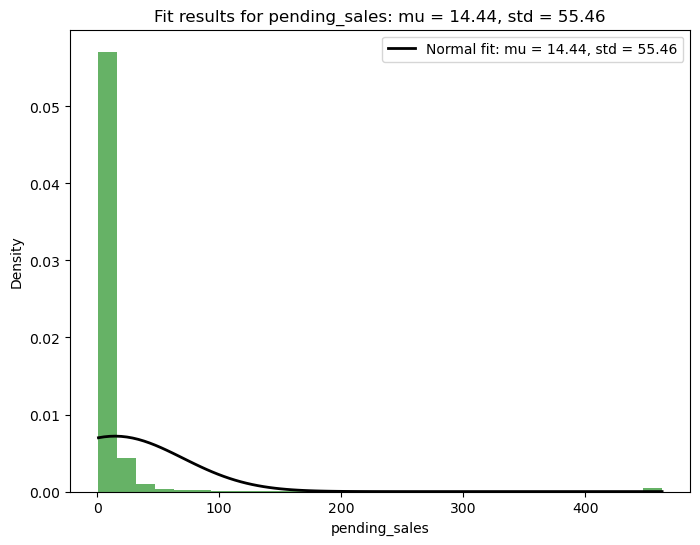

Writing PMF - inventory.pdf
Writing PMF - inventory.png


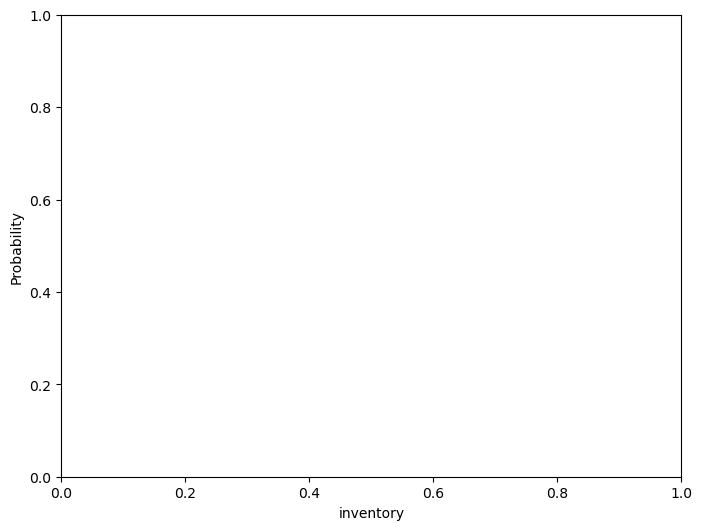

Writing CDF - inventory.pdf
Writing CDF - inventory.png


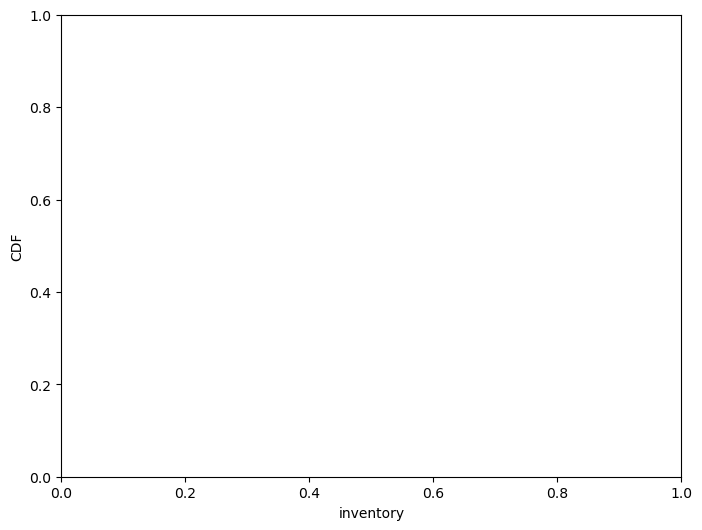

<Figure size 800x600 with 0 Axes>

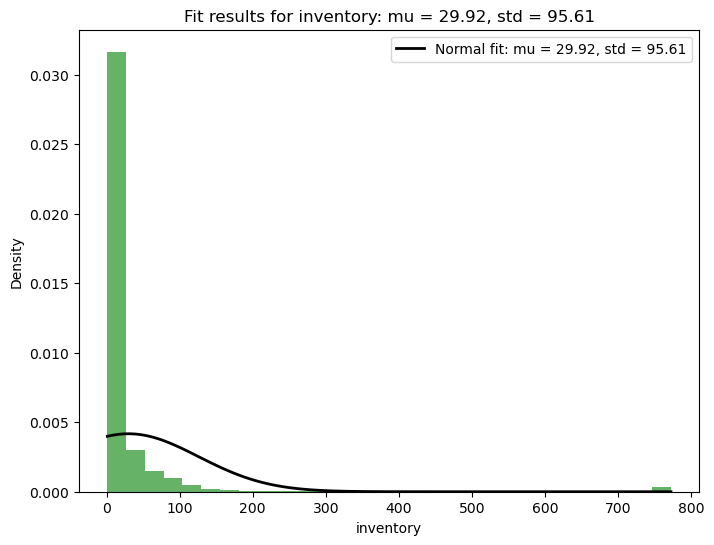

Writing PMF - months_of_supply.pdf
Writing PMF - months_of_supply.png


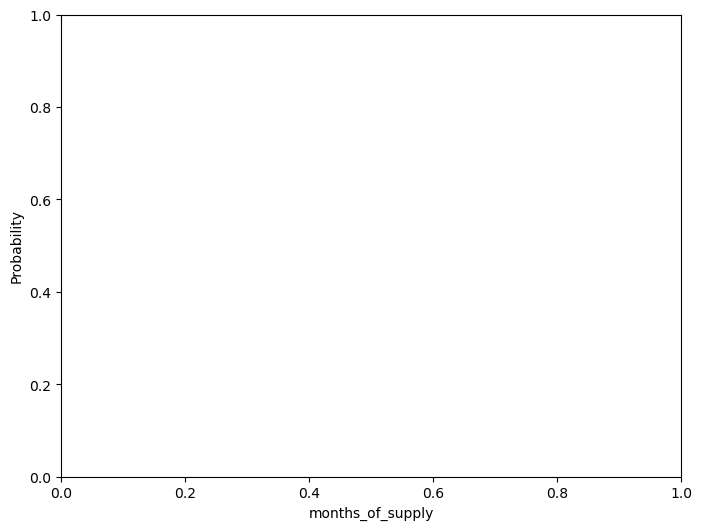

Writing CDF - months_of_supply.pdf
Writing CDF - months_of_supply.png


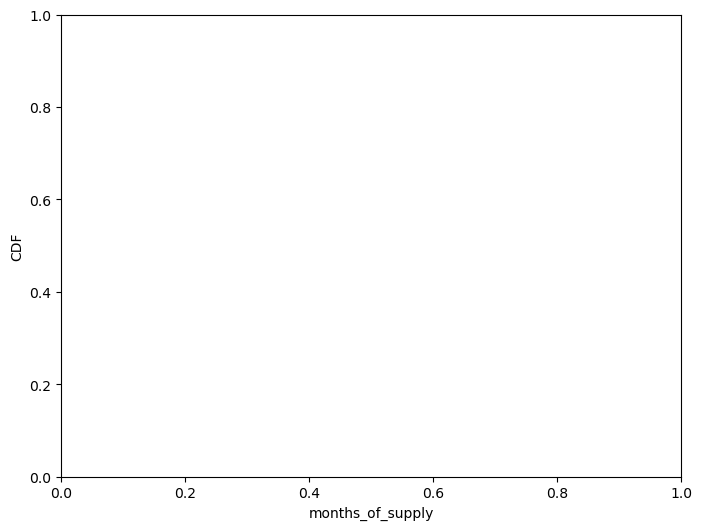

<Figure size 800x600 with 0 Axes>

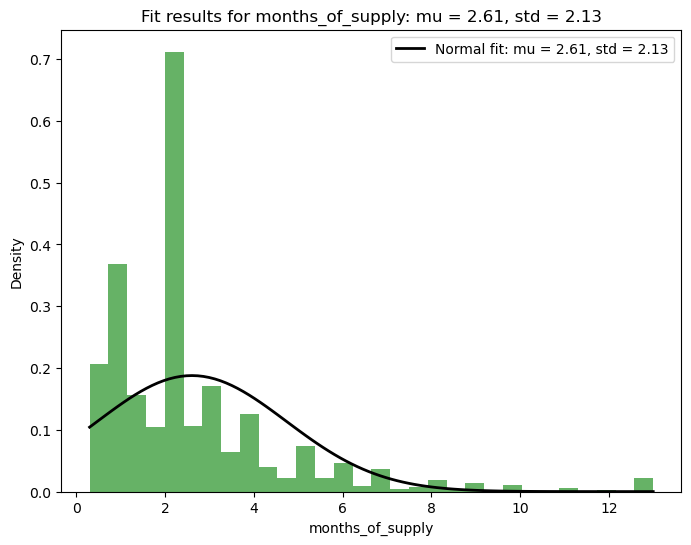

Writing PMF - median_dom.pdf
Writing PMF - median_dom.png


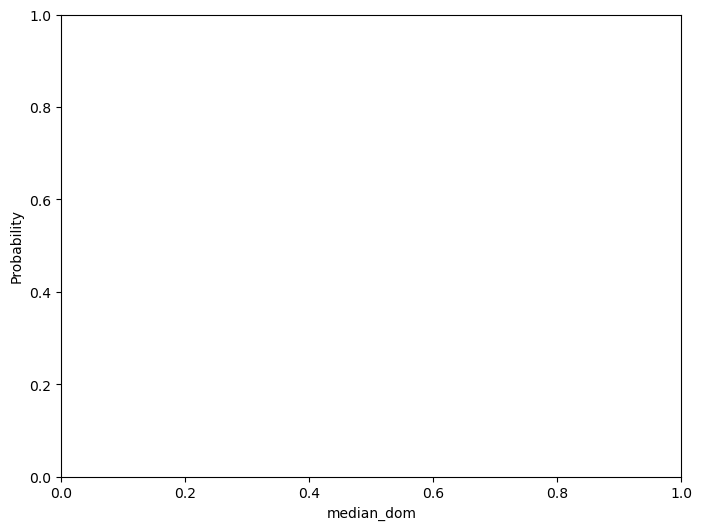

Writing CDF - median_dom.pdf
Writing CDF - median_dom.png


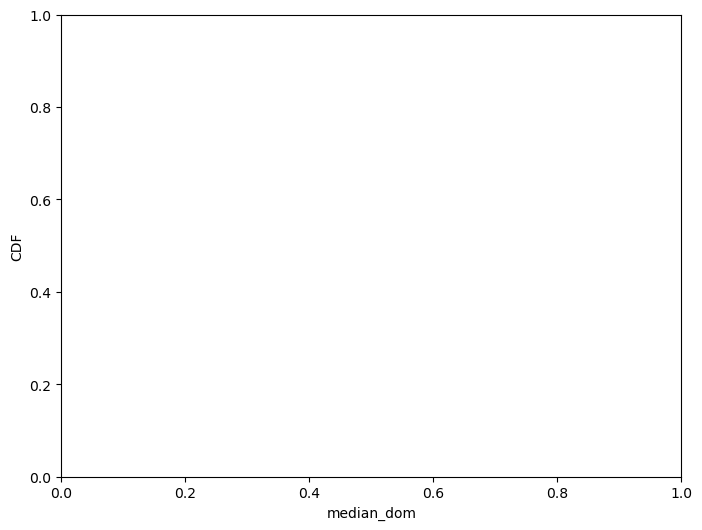

<Figure size 800x600 with 0 Axes>

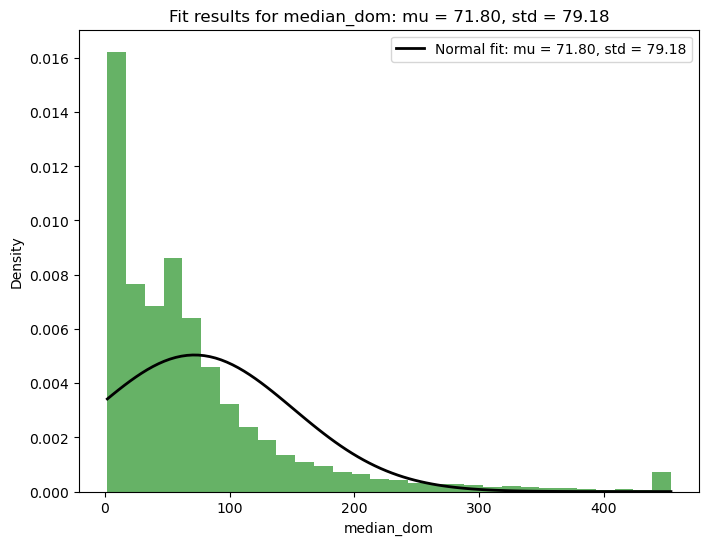

In [17]:
# Loop through each numeric column to compute and visualize PMF, CDF, and analytical distributions
for var in df_interpolated_ct.select_dtypes(include=[np.number]).columns:
    
    # Probability Mass Function (PMF) visualization
    pmf = thinkstats2.Pmf(df_interpolated_ct[var], label=f'PMF of {var}')
    thinkplot.Pmf(pmf)
    pmf_filename = f'PMF - {var}'
    thinkplot.Save(root=pmf_filename)
    thinkplot.Show(xlabel=var, ylabel='Probability')
    
    # Cumulative Distribution Function (CDF) visualization
    cdf = thinkstats2.Cdf(df_interpolated_ct[var], label=f'CDF of {var}')
    thinkplot.Cdf(cdf)
    cdf_filename = f'CDF - {var}'
    thinkplot.Save(root=cdf_filename)
    thinkplot.Show(xlabel=var, ylabel='CDF')
    
    # Fit and plot a normal distribution to the data
    mu, std = stats.norm.fit(df_interpolated_ct[var])
    xmin, xmax = df_interpolated_ct[var].min(), df_interpolated_ct[var].max()
    x = np.linspace(xmin, xmax, 100)
    p = stats.norm.pdf(x, mu, std)
    
    plt.figure(figsize=(8, 6))
    plt.plot(x, p, 'k', linewidth=2)
    plt.hist(df_interpolated_ct[var], bins=30, density=True, alpha=0.6, color='g')
    plt.title(f'Fit results for {var}: mu = {mu:_.2f}, std = {std:_.2f}')
    plt.legend([f'Normal fit: mu = {mu:_.2f}, std = {std:_.2f}'])
    plt.xlabel(var)
    plt.ylabel('Density')
    distribution_filename = f'DISTRIBUTION - {var}'
    plt.savefig(distribution_filename)
    plt.show()

## Scatter Plots and Correlation Analysis

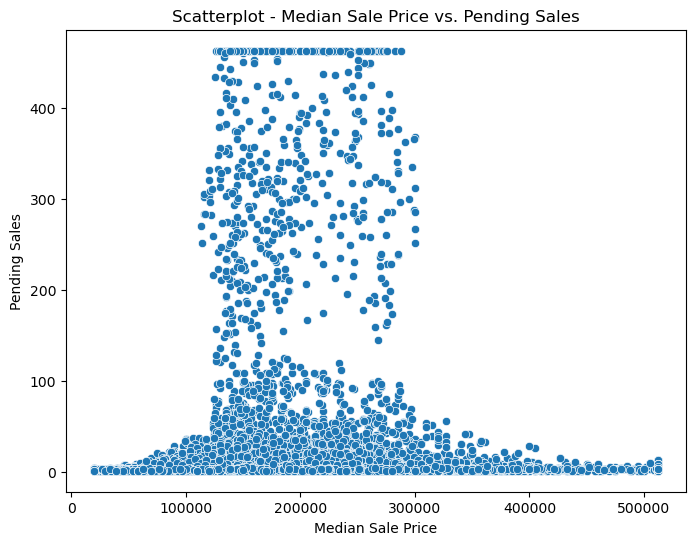

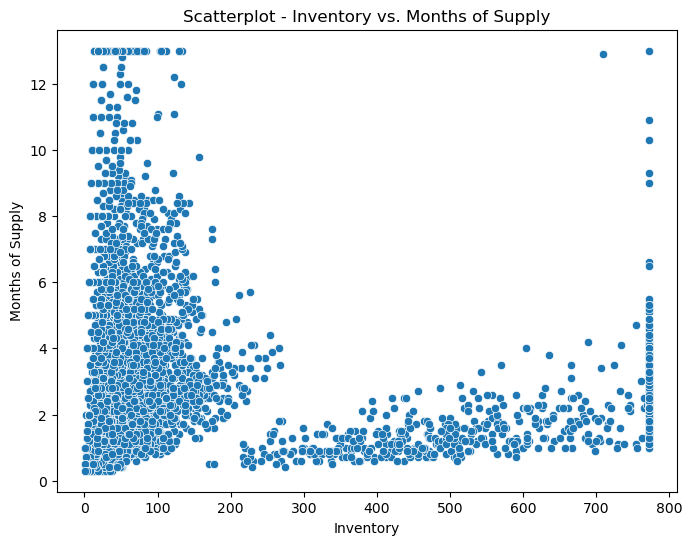

Covariance between Median Sale Price and Pending Sales: 285_321.52
Covariance between Inventory and Months of Supply: 7.61
Spearman's Rank Correlation between Median Sale Price and Pending Sales: 0.21
Spearman's Rank Correlation between Inventory and Months of Supply: 0.47


In [18]:
# Add date columns back to the DataFrame for time series analysis and further correlation studies
df_interpolated_date_cols = pd.concat([df_interpolated_ct, df_interpolated[date_cols]], axis=1)

# Scatter plot between 'median_sale_price' and 'pending_sales'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='median_sale_price', y='pending_sales', data=df_interpolated_date_cols)
fig_title = 'Scatterplot - Median Sale Price vs. Pending Sales'
plt.title(fig_title)
plt.xlabel('Median Sale Price')
plt.ylabel('Pending Sales')
plt.savefig(f'{fig_title}.png')
plt.show()

# Scatter plot between 'inventory' and 'months_of_supply'
plt.figure(figsize=(8, 6))
sns.scatterplot(x='inventory', y='months_of_supply', data=df_interpolated_date_cols)
fig2_title = 'Scatterplot - Inventory vs. Months of Supply'
plt.title(fig2_title)
plt.xlabel('Inventory')
plt.ylabel('Months of Supply')
plt.savefig(f'{fig2_title}.png')
plt.show()

# Calculate covariance between 'median_sale_price' and 'pending_sales'
covariance_price_sales = df_interpolated_date_cols['median_sale_price'].cov(df_interpolated_date_cols['pending_sales'])

# Calculate covariance between 'inventory' and 'months_of_supply'
covariance_inventory_supply = df_interpolated_date_cols['inventory'].cov(df_interpolated_date_cols['months_of_supply'])

print(f"Covariance between Median Sale Price and Pending Sales: {covariance_price_sales:_.2f}")
print(f"Covariance between Inventory and Months of Supply: {covariance_inventory_supply:_.2f}")

# Calculate Spearman's rank correlation coefficient between 'median_sale_price' and 'pending_sales'
spearman_price_sales = df_interpolated_date_cols['median_sale_price'].corr(df_interpolated_date_cols['pending_sales'], method='spearman')

# Calculate Spearman's rank correlation coefficient between 'inventory' and 'months_of_supply'
spearman_inventory_supply = df_interpolated_date_cols['inventory'].corr(df_interpolated_date_cols['months_of_supply'], method='spearman')

print(f"Spearman's Rank Correlation between Median Sale Price and Pending Sales: {spearman_price_sales:_.2f}")
print(f"Spearman's Rank Correlation between Inventory and Months of Supply: {spearman_inventory_supply:_.2f}")

In [15]:
for i in df_interpolated_date_cols.columns:
    print(i)

median_sale_price
pending_sales
inventory
months_of_supply
median_dom
period_begin
period_end
last_updated


## Hypothesis Testing and Regression Analysis

In [16]:
# Group data by year for comparison (e.g., 2022 vs 2023)
group1 = df_interpolated_date_cols[df_interpolated_date_cols['period_begin'].dt.year == 2022]['median_sale_price']
group2 = df_interpolated_date_cols[df_interpolated_date_cols['period_begin'].dt.year == 2023]['median_sale_price']

# Perform t-test and output the results
t_stat, p_value = ttest_ind(group1, group2)
print(f"T-test results: t-statistic = {t_stat}, p-value = {p_value}")

# Perform regression analysis to identify the relationship between median sale price and other factors
model = smf.ols('median_sale_price ~ pending_sales + inventory + months_of_supply + median_dom', data=df_interpolated_date_cols).fit()
print(model.summary())

T-test results: t-statistic = nan, p-value = nan
                            OLS Regression Results                            
Dep. Variable:      median_sale_price   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     275.5
Date:                Sat, 10 Aug 2024   Prob (F-statistic):          3.77e-232
Time:                        16:38:23   Log-Likelihood:            -3.1634e+05
No. Observations:               24724   AIC:                         6.327e+05
Df Residuals:                   24719   BIC:                         6.327e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

# Summary of Analysis
## Outcome of the Exploratory Data Analysis (EDA):
**The EDA revealed several key insights:**
1. Distribution and Outliers: Histograms and KDE plots for each variable showed the general distribution patterns, with some variables like median_sale_price and pending_sales being relatively normally distributed, while others, such as months_of_supply, showed more variability. Outliers were identified and managed using winsorization to prevent them from skewing the analysis.
2. Descriptive Statistics: The mean, mode, spread, and tails of each variable were calculated. The data indicated that median_sale_price had a mean close to the mode, suggesting a somewhat symmetric distribution. Inventory and months_of_supply showed more skewness, suggesting they might have a more significant impact on market conditions.
3. Correlations: The correlation matrix highlighted that pending_sales had a strong positive correlation with inventory, indicating that as more homes are available, more sales are pending. However, the relationship between median_sale_price and months_of_supply was slightly negative, suggesting that as supply increases relative to demand, prices tend to drop.

**What Was Missed During the Analysis?**
The analysis was comprehensive, but further granularity could have been achieved by segmenting the data by property type (e.g., single-family homes, condos) or by different regions within Nebraska. This would provide a more nuanced understanding of how these factors influence prices across various segments of the market.

**Were There Any Variables That Could Have Helped?**
Additional variables, such as interest rates or economic indicators like employment rates, could have provided more context to the housing market dynamics. These factors often influence buyer behavior and, consequently, market prices.

**Were There Any Assumptions Made That Were Incorrect?**
The assumption that the relationships between variables are linear and can be captured through simple correlation and regression may not fully capture the complexities of the real estate market. Non-linear relationships or interactions between variables could play a significant role and may require more advanced modeling techniques.

**Challenges Faced and Areas of Uncertainty?**
One of the main challenges was handling missing data and ensuring that outliers were appropriately managed without losing critical information. Additionally, interpreting the relationships between variables, especially when they were not strongly correlated, required careful consideration of the underlying market dynamics.

In summary, the analysis provided valuable insights into the housing market in Nebraska, showing that supply and demand factors play crucial roles in determining median sale prices. However, additional data and more sophisticated models that include more of the available features in the utilized dataset could further enhance the understanding of these dynamics.